In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, roc_auc_score

Using TensorFlow backend.


In [2]:
# Logistic Regression Function

def lrcv(k, X, y):
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    mms = MinMaxScaler()
    # Train a logistic regression for each fold
    aucs = []
    kappas = []
    # Calculate metrics for each affect
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train_raw, y_test_raw = y[train_index], y[test_index]
        
        y_train = np.zeros((y_train_raw.size, y_train_raw.max()+1))
        y_train[np.arange(y_train_raw.size),y_train_raw] = 1
        y_test = np.zeros((y_test_raw.size, y_test_raw.max()+1))
        y_test[np.arange(y_test_raw.size),y_test_raw] = 1
        
        log_reg = Sequential()
        log_reg.add(Dense(4, activation='sigmoid', input_shape=(X_train.shape[1],)))
        log_reg.compile(optimizer='adam', loss='categorical_crossentropy')
        es = [EarlyStopping(monitor='loss', patience=5, min_delta=0.0001)]
        log_reg.fit(X_train, y_train, callbacks=es, verbose=False)
        
        y_pred = log_reg.predict(X_test)
        for y_t, y_p in zip(y_test.T, y_pred.T):
            aucs.append(roc_auc_score(y_t, y_p))
            kappas.append(cohen_kappa_score(y_t, np.around(y_p)))
    return np.mean(aucs), np.mean(kappas)

In [ ]:
# BOREP

TRIALS = 1
FOLDS = 5
MAX_POWER = 12

input_data = pk.load(open('input_data.pkl', 'rb'))
target_data = pk.load(open('target_data.pkl', 'rb'))

pooling = []
dimention = []
auc = []
kappa = []

for pooling_name, pooling_function in zip(['Max Pooling', 'Mean Pooling'], [np.max, np.mean]):
    for dim in np.power(2, np.arange(MAX_POWER+1)):
        print(pooling_name, dim)
        aucs = []
        kappas = []
        for i in range(TRIALS):
            random_embedding = (np.random.rand(input_data[0].shape[1], dim) * 2 - 1) / np.sqrt(input_data[0].shape[1])
            log_input = []
            for input_batch in input_data:
                embedded_input = np.dot(input_batch, random_embedding)
                embedded_input = pooling_function(embedded_input, axis=0)
                log_input.append(embedded_input)
            log_input = np.stack(log_input)
            # Get the average auc and kappa for all affects and folds
            mean_auc, mean_kappa = lrcv(FOLDS, log_input, np.argmax(target_data, axis=1).astype(int))
            aucs.append(mean_auc)
            kappas.append(mean_kappa)
        pooling.append(pooling_name)
        dimention.append(log_input.shape[1])
        auc.append(np.mean(aucs))
        kappa.append(np.mean(kappas))

In [ ]:
plt.figure()
plt.plot(dimention[MAX_POWER+1:], auc[MAX_POWER+1:], marker='.', label='Max Pooling')
plt.plot(dimention[:MAX_POWER+1], auc[:MAX_POWER+1], marker='.', label='Mean Pooling')
plt.xlabel('Projected Dimensions')
plt.ylabel('ROC AUC')
plt.title('Bag of Random Embeddings Results')
plt.legend()
plt.show()

plt.figure()
plt.plot(dimention[MAX_POWER+1:], kappa[MAX_POWER+1:], marker='.', label='Max Pooling')
plt.plot(dimention[:MAX_POWER+1], kappa[:MAX_POWER+1], marker='.', label='Mean Pooling')
plt.xlabel('Projected Dimensions')
plt.ylabel('Cohen\'s Kappa')
plt.title('Bag of Random Embeddings Results')
plt.legend()
plt.show()

In [3]:
# RLSTM

TRIALS = 1
FOLDS = 5
MAX_POWER = 12
LAYERS = 3

input_data = pk.load(open('input_data.pkl', 'rb'))
target_data = pk.load(open('target_data.pkl', 'rb'))

layers = []
dimention = []
auc = []
kappa = []

for lay in range(1,LAYERS+1):
    for dim in np.power(2, np.arange(MAX_POWER+1)):
        print(lay, dim)
        aucs = []
        kappas = []
        for i in range(TRIALS):
            # Make the LSTM
            rand_lstm = Sequential()
            rand_lstm.add(LSTM(dim, activation='tanh', return_sequences=True, input_shape=(1, input_data[0].shape[1])))
            for l in range(lay-1):
                rand_lstm.add(LSTM(dim, activation='tanh', return_sequences=True))
            rand_lstm.compile(optimizer='adam', loss='mse')
            # Project each input into higher dimensions
            log_input = []
            for input_batch in input_data:
                input_batch = input_batch.reshape(input_batch.shape[0], 1, input_batch.shape[1])
                batch_out = rand_lstm.predict(input_batch)
                log_input.append(batch_out[-1,:,:].flatten())
                rand_lstm.reset_states()
            log_input = np.stack(log_input)
            # Get the average auc and kappa for all affects and folds
            mean_auc, mean_kappa = lrcv(FOLDS, log_input, np.argmax(target_data, axis=1).astype(int))
            aucs.append(mean_auc)
            kappas.append(mean_kappa)
        layers.append(lay)
        dimention.append(log_input.shape[1])
        auc.append(np.mean(aucs))
        kappa.append(np.mean(kappas))

1 1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1 2
1 4
1 8
1 16
1 32
1 64
1 128
1 256
1 512
1 1024
1 2048
1 4096
2 1
2 2
2 4
2 8
2 16
2 32
2 64
2 128
2 256
2 512
2 1024
2 2048
2 4096
3 1
3 2
3 4
3 8
3 16
3 32
3 64
3 128
3 256
3 512
3 1024
3 2048
3 4096


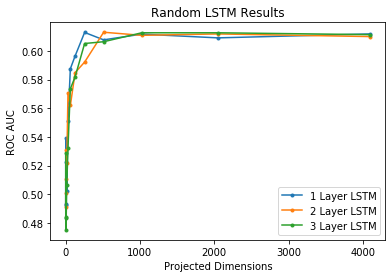

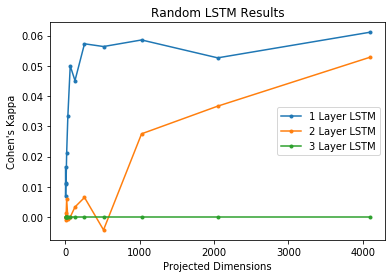

In [4]:
plt.figure()
for i in range(3):
    plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], auc[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i+1} Layer LSTM')
plt.xlabel('Projected Dimensions')
plt.ylabel('ROC AUC')
plt.title('Random LSTM Results')
plt.legend()
plt.show()

plt.figure()
for i in range(3):
    plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], kappa[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i+1} Layer LSTM')
plt.xlabel('Projected Dimensions')
plt.ylabel('Cohen\'s Kappa')
plt.title('Random LSTM Results')
plt.legend()
plt.show()

In [5]:
# RBLSTM

TRIALS = 1
FOLDS = 5
MAX_POWER = 11
LAYERS = 3

input_data = pk.load(open('input_data.pkl', 'rb'))
target_data = pk.load(open('target_data.pkl', 'rb'))

layers = []
dimention = []
auc = []
kappa = []

for lay in range(1,LAYERS+1):
    for dim in np.power(2, np.arange(MAX_POWER+1)):
        print(lay, dim)
        aucs = []
        kappas = []
        for i in range(TRIALS):
            # Make the LSTM
            rand_lstm = Sequential()
            rand_lstm.add(Bidirectional(LSTM(dim, activation='tanh', return_sequences=True), input_shape=(1, input_data[0].shape[1])))
            for l in range(lay-1):
                rand_lstm.add(Bidirectional(LSTM(dim, activation='tanh', return_sequences=True)))
            rand_lstm.compile(optimizer='adam', loss='categorical_crossentropy')
            # Project each input into higher dimensions
            log_input = []
            for input_batch in input_data:
                input_batch = input_batch.reshape(input_batch.shape[0], 1, input_batch.shape[1])
                batch_out = rand_lstm.predict(input_batch)
                log_input.append(batch_out[-1,:,:].flatten())
                rand_lstm.reset_states()
            log_input = np.stack(log_input)
            # Get the average auc and kappa for all affects and folds
            mean_auc, mean_kappa = lrcv(FOLDS, log_input, np.argmax(target_data, axis=1).astype(int))
            aucs.append(mean_auc)
            kappas.append(mean_kappa)
        layers.append(lay)
        dimention.append(log_input.shape[1])
        auc.append(np.mean(aucs))
        kappa.append(np.mean(kappas))

1 1
1 2
1 4
1 8
1 16
1 32
1 64
1 128
1 256
1 512
1 1024
1 2048
2 1
2 2
2 4
2 8
2 16
2 32


KeyboardInterrupt: 

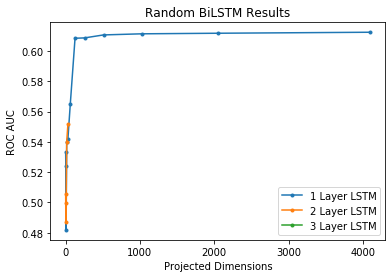

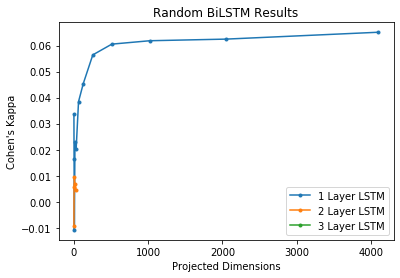

In [7]:
plt.figure()
for i in range(3):
    plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], auc[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i+1} Layer LSTM')
plt.xlabel('Projected Dimensions')
plt.ylabel('ROC AUC')
plt.title('Random BiLSTM Results')
plt.legend()
plt.show()

plt.figure()
for i in range(3):
    plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], kappa[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i+1} Layer LSTM')
plt.xlabel('Projected Dimensions')
plt.ylabel('Cohen\'s Kappa')
plt.title('Random BiLSTM Results')
plt.legend()
plt.show()

In [ ]:
# MLRBLSTM

TRIALS = 5
FOLDS = 5
MAX_POWER = 11
LAYERS = 3

input_data = pk.load(open('input_data.pkl', 'rb'))
target_data = pk.load(open('target_data.pkl', 'rb'))

layers = []
dimention = []
auc = []
kappa = []

for lay in range(1,4):
    for dim in np.power(2, np.arange(MAX_POWER+1)):
        print(lay, dim)
        aucs = []
        kappas = []
        for i in range(TRIALS):
            # Make the LSTM
            rand_lstm = Sequential()
            rand_lstm.add(Bidirectional(LSTM(max(dim-lay+1, 1), activation='tanh', return_sequences=True), input_shape=(1, input_data[0].shape[1])))
            for l in range(lay-1):
                rand_lstm.add(Bidirectional(LSTM(max(dim-lay+1, 1), activation='tanh', return_sequences=True)))
            rand_lstm.compile(optimizer='adam', loss='categorical_crossentropy')
            outputs =[l.output for l in rand_lstm.layers]
            inter_model = keras.Model(inputs=rand_lstm.inputs, outputs=outputs)
            # Project each input into higher dimensions
            log_input = []
            for input_batch in input_data:
                input_batch = input_batch.reshape(input_batch.shape[0], 1, input_batch.shape[1])
                batch_out = np.stack(inter_model.predict(input_batch))
                batch_out = batch_out[-1,:,:].flatten() if lay == 1 else batch_out[:,-1,:,:].flatten()
                log_input.append(batch_out)
                rand_lstm.reset_states()
            log_input = np.stack(log_input)
            # Get the average auc and kappa for all affects and folds
            mean_auc, mean_kappa = lrcv(FOLDS, log_input, np.array(target_data).astype(int))
            aucs.append(mean_auc)
            kappas.append(mean_kappa)
        layers.append(lay)
        dimention.append(log_input.shape[1])
        auc.append(np.mean(aucs))
        kappa.append(np.mean(kappas))

In [ ]:
plt.figure()
for i in range(3):
    plt.plot(dimention[i*MAX_POWER+1:i*MAX_POWER+1+MAX_POWER+1], auc[i*MAX_POWER+1:i*MAX_POWER+1+MAX_POWER+1], marker='.', label=f'{i+1} Layer LSTM')
plt.xlabel('Projected Dimensions')
plt.ylabel('ROC AUC')
plt.title('Interlayer Random Bidirectional LSTM Results')
plt.legend()
plt.show()

plt.figure()
for i in range(3):
    plt.plot(dimention[i*MAX_POWER+1:i*MAX_POWER+1+MAX_POWER+1], kappa[i*MAX_POWER+1:i*MAX_POWER+1+MAX_POWER+1], marker='.', label=f'{i+1} Layer LSTM')
plt.xlabel('Projected Dimensions')
plt.ylabel('Cohen\'s Kappa')
plt.title('Interlayer Random Bidirectional LSTM Results')
plt.legend()
plt.show()